# Building RAG Chatbots with Langchain

In [2]:
# !python -m venv openai-env

In [3]:
# !pip install -r requirements.txt

In [4]:
!openai-env\Scripts\activate

In [5]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
pdf_folder_path = 'C:\\Users\\Rajan\\OneDrive - University College London\\MSc - Multimodal Project\\Literature\\Papers\\'

In [7]:
from langchain.document_loaders import PyPDFLoader,PyPDFDirectoryLoader

loader = PyPDFDirectoryLoader(pdf_folder_path)
docs = loader.load()
len(docs)


813

In [8]:
print(docs[0].page_content)

UniXGen: A Uniﬁed Vision-Language Model for
Multi-View Chest X-ray Generation and Report
Generation
Hyungyung Lee1, Da Young Lee2∗, Wonjae Kim3, Jin-Hwa Kim3,4
Tackeun Kim5, Jihang Kim5, Leonard Sunwoo5, Edward Choi1
1KAIST,2Deep-in-Sight Co.,3Naver AI Lab,4SNU AIIS,
5Seoul National University Bundang Hospital
ttumyche@kaist.ac.kr, dyan.lee717@gmail.com, wonjae.kim@navercorp.com ,
j1nhwa.kim@navercorp.com, tackeun.kim@snu.ac.kr, radio622@gmail.com ,
leonard.sunwoo@gmail.com, edwardchoi@kaist.ac.kr
Abstract
Generated synthetic data in medical research can substitute privacy and security-
sensitive data with a large-scale curated dataset, reducing data collection and
annotation costs. As part of this effort, we propose UniXGen, a uniﬁed chest X-ray
and report generation model, with the following contributions. First, we design a
uniﬁed model for bidirectional chest X-ray and report generation by adopting a
vector quantization method to discretize chest X-rays into discrete visual tokens 

To count the number of tokens that gpt-3.5-turbo will use for some text we need to initialize the tiktoken tokenizer.

In [9]:
import tiktoken

tokenizer = tiktoken.get_encoding('cl100k_base')

# create the length function
def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

Note that for the tokenizer we defined the encoder as "cl100k_base". This is a specific tiktoken encoder which is used by gpt-3.5-turbo, as well as gpt-4, and text-embedding-ada-002 which are models supported by OpenAI at the time of this writing. 

In [10]:
tiktoken.encoding_for_model('gpt-3.5-turbo')

<Encoding 'cl100k_base'>

Using the __tiktoken_len__ function, let's count and visualize the number of tokens across our webpages.

In [11]:
token_counts = [tiktoken_len(doc.page_content) for doc in docs]

Let's see min, average, and max values:

In [12]:
print(f"""Min: {min(token_counts)}
Avg: {int(sum(token_counts) / len(token_counts))}
Max: {max(token_counts)}""")

Min: 27
Avg: 1129
Max: 32261


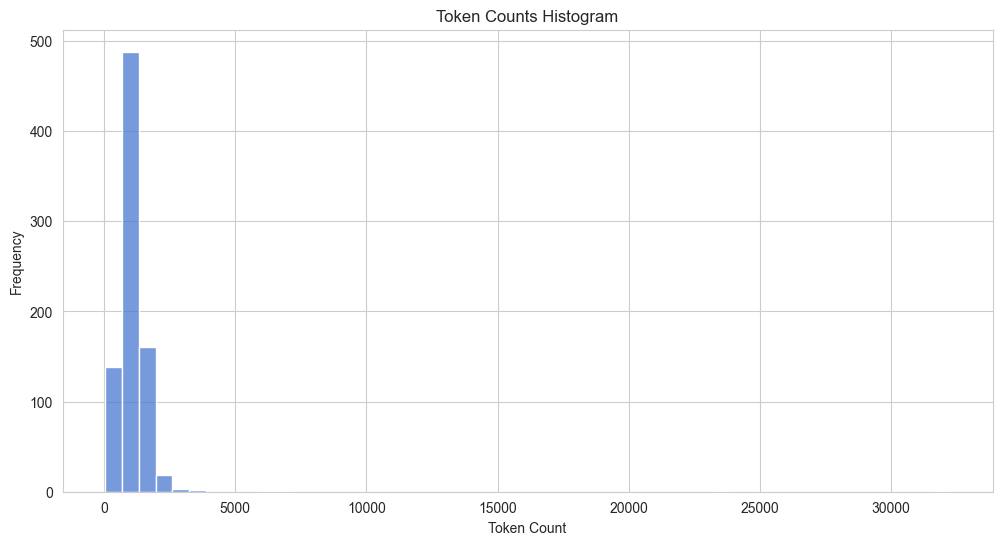

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# set style and color palette for the plot
sns.set_style("whitegrid")
sns.set_palette("muted")

# create histogram
plt.figure(figsize=(12, 6))
sns.histplot(token_counts, kde=False, bins=50)

# customize the plot info
plt.title("Token Counts Histogram")
plt.xlabel("Token Count")
plt.ylabel("Frequency")

plt.show()

## Chunking the Text
At the time of writing, gpt-3.5-turbo supports a context window of 4096 tokens — that means that input tokens + generated ( / completion) output tokens, cannot total more than 4096 without hitting an error.

So we 100% need to keep below this. If we assume a very safe margin of ~2000 tokens for the input prompt into gpt-3.5-turbo, leaving ~2000 tokens for conversation history and completion.

With this ~2000 token limit we may want to include five snippets of relevant information, meaning each snippet can be no more than 400 token long.

To create these snippets we use the RecursiveCharacterTextSplitter from LangChain. To measure the length of snippets we also need a length function. This is a function that consumes text, counts the number of tokens within the text (after tokenization using the gpt-3.5-turbo tokenizer), and returns that number. 

In [14]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=20,  # number of tokens overlap between chunks
    length_function=tiktoken_len,
    separators=['\n\n','\n', ' ', '']
)

Then we split the text for a document like so:

In [15]:
chunks = text_splitter.split_text(docs[5].page_content)
len(chunks)

3

In [16]:
tiktoken_len(chunks[0]), tiktoken_len(chunks[1]), tiktoken_len(chunks[2])

(391, 374, 112)

In [17]:
chunks[1]

'F1.\n4.2.3 Human Evaluation\nUsing 100 triples of an original chest X-ray generated chest X-rays from our model and a baseline,\nwe ask three board-certiﬁed clinicians to evaluate each chest X-ray on three aspects: (1) realism, (2)\nalignment with the given report, and (3) the view position among PA, AP, and LATERAL views. Both\n(1) and (2) are rated on a scale from 1 (worst) to 5 (best). The triples consist of 33 triples from PA and\nAP and 34 triples from LATERAL. The clinicians consist of two radiologists and one neurosurgeon,\nand the X-rays are presented in random order for each triple.\n4.3 Experiment Design\nExperiments are designed to investigate the followings:\nThe Advantage of the Uniﬁed Model\nWe evaluate the advantage of a bidirectional uniﬁed model compared to separate models for chest\nX-ray and radiology report generation. There are four variants: 1) Single AP, 2) Single PA, 3)\nSingle LAT. , and 4) Single report . Each model is only trained to maximize the log-likelih

For docs[5] we created 2 chunks of token length 391, 374 and 112.

## Building the Knowledge Base - Vector Database

In [18]:
from langchain.embeddings.openai import OpenAIEmbeddings
import faiss
import numpy as np

# Create a FAISS index for the specified dimension
dimension = 1536
index = faiss.IndexFlatL2(dimension)

# get openai api key from platform.openai.com
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY') or getpass("OpenAI API Key: ")

# Embedding model
embed_model = OpenAIEmbeddings(model="text-embedding-ada-002", openai_api_key=OPENAI_API_KEY)

In [19]:
import tqdm
import time

texts = []
metadatas = []
embeddings = [] 

# Loop over the documents
for doc in tqdm.tqdm(docs):  # Added tqdm for progress tracking
    # Extract the text content from each Document object
    doc_text = doc.page_content
    # Split text into chunks
    chunks = text_splitter.split_text(doc_text)
    # Create individual metadata dicts for each chunk
    record_metadatas = [{"chunk": j, "text": doc_text} for j, doc_text in enumerate(chunks)]

    # append these to current batches
    texts.extend(chunks)
    metadatas.extend(record_metadatas)
    

    for chunk in chunks:
        # Embed each chunk
        embed = embed_model.embed_documents([chunk])
        embed = np.array(embed).astype('float32')
        embeddings.extend(embed)  # Store embeddings in a list
        index.add(embed)

  0%|          | 0/813 [00:00<?, ?it/s]

100%|██████████| 813/813 [11:24<00:00,  1.19it/s]  


# Quering the VectorStore

In [20]:
k = 4
xq = np.array(embed_model.embed_query("what is the flamingo model")).astype('float32')
if xq.ndim == 1:
    xq = xq.reshape(1, -1)


In [21]:
D, I = index.search(xq, k)  # search
print(I)

[[1108 1617 2502 2726]]


In [22]:
# Perform the FAISS search
D, I = index.search(xq, k)  # I contains the indexes of the closest vectors
print("Indexes:", I)

# Retrieve the corresponding texts
for i, indexes in enumerate(I):
    print(f"Results for Query {i}:")
    for idx in indexes:
        if idx >= 0:  # Check if the index is valid
            print(texts[idx])
        else:
            print("No valid result for this index.")

Indexes: [[1108 1617 2502 2726]]
Results for Query 0:
🦩
Flamingo: a Visual Language Model
for Few-Shot Learning
Jean-Baptiste Alayrac*,‡Jeff Donahue*Pauline Luc*Antoine Miech*
Iain Barr†Yana Hasson†Karel Lenc†Arthur Mensch†Katie Millican†
Malcolm Reynolds†Roman Ring†Eliza Rutherford†Serkan Cabi Tengda Han
Zhitao Gong Sina Samangooei Marianne Monteiro Jacob Menick
Sebastian Borgeaud Andrew Brock Aida Nematzadeh Sahand Sharifzadeh
Mikolaj Binkowski Ricardo Barreira Oriol Vinyals Andrew Zisserman
Karen Simonyan*,‡
*Equal contributions, ordered alphabetically,†Equal contributions, ordered alphabetically,
‡Equal senior contributions
DeepMind
Abstract
Building models that can be rapidly adapted to novel tasks using only a handful of
annotated examples is an open challenge for multimodal machine learning research.
We introduce Flamingo, a family of Visual Language Models (VLM) with this
ability. We propose key architectural innovations to: (i) bridge powerful pretrained
vision-only and langua

In [23]:
# Perform the FAISS search
D, I = index.search(xq, k)  # I contains the indexes of the closest vectors
print("Indexes:", I)

context_texts = []
for i, indexes in enumerate(I):
    for idx in indexes:
        context = metadatas[idx]['text']
        context_texts.append(context)


Indexes: [[1108 1617 2502 2726]]


In [24]:
def generate_rag_prompt(query, embed_model, index, k=5):
    """
    Generates a prompt for a Retrieve-and-Generate (RAG) task using a FAISS database for similarity search.

    Parameters:
    - query: The user's question or query as a string.
    - embed_model: The embedding model used to convert text to vectors.
    - index: The FAISS index containing the embeddings.
    - k: The number of similar documents to retrieve.

    Returns:
    A string that serves as a prompt for the language model, incorporating context from the similarity search.
    """

    # Convert the query to a vector using the embedding model
    query_vector = np.array(embed_model.embed_query(query)).astype('float32')
    if query_vector.ndim == 1:
        query_vector = xq.reshape(1, -1)
    
    # Perform the similarity search in the FAISS index
    D, I = index.search(query_vector, k)
    
    # Retrieve and format the text of the relevant document chunks
    context_texts = []
    for i, indexes in enumerate(I):
        for idx in indexes:
            context = metadatas[idx]['text']
            context_texts.append(context)
    
    # Construct the prompt by combining the query with the retrieved contexts
    prompt = f"Question: {query}\n\n"
    prompt += "Relevant information:\n"
    for i, text in enumerate(context_texts, start=1):
        prompt += f"\n{i}. {text}\n"
    
    return prompt

In [25]:
query = "what is the flamingo model?"
prompt = generate_rag_prompt(query, embed_model, index, k=3)
print(prompt)

Question: what is the flamingo model?

Relevant information:

1. 🦩
Flamingo: a Visual Language Model
for Few-Shot Learning
Jean-Baptiste Alayrac*,‡Jeff Donahue*Pauline Luc*Antoine Miech*
Iain Barr†Yana Hasson†Karel Lenc†Arthur Mensch†Katie Millican†
Malcolm Reynolds†Roman Ring†Eliza Rutherford†Serkan Cabi Tengda Han
Zhitao Gong Sina Samangooei Marianne Monteiro Jacob Menick
Sebastian Borgeaud Andrew Brock Aida Nematzadeh Sahand Sharifzadeh
Mikolaj Binkowski Ricardo Barreira Oriol Vinyals Andrew Zisserman
Karen Simonyan*,‡
*Equal contributions, ordered alphabetically,†Equal contributions, ordered alphabetically,
‡Equal senior contributions
DeepMind
Abstract
Building models that can be rapidly adapted to novel tasks using only a handful of
annotated examples is an open challenge for multimodal machine learning research.
We introduce Flamingo, a family of Visual Language Models (VLM) with this
ability. We propose key architectural innovations to: (i) bridge powerful pretrained
vision-only

In [26]:
import os
from langchain.chat_models import ChatOpenAI

chat = ChatOpenAI(
    openai_api_key=os.environ["OPENAI_API_KEY"],
    model='gpt-3.5-turbo'
)

In [27]:
from langchain.schema import (
    SystemMessage,
    HumanMessage,
    AIMessage
)

messages = [
    SystemMessage(content="You are a helpful assistant."),
    HumanMessage(content="Hi AI, how are you today?"),
    AIMessage(content="I'm great thank you. How can I help you?"),
    HumanMessage(content="I'd like to understand string theory.")
]

In [28]:
res = chat(messages)
res

AIMessage(content='String theory is a theoretical framework in physics that attempts to explain the fundamental nature of particles and forces in the universe. It proposes that the most basic building blocks of the universe are not point-like particles, but rather tiny vibrating strings. These strings can vibrate at different frequencies, giving rise to different particles and forces.\n\nString theory is a complex and mathematically rigorous theory that attempts to unify quantum mechanics and general relativity, which are currently the two main pillars of modern physics. While string theory has not yet been proven experimentally, it has generated a lot of interest and research in the physics community due to its potential to provide a unified description of all fundamental forces in the universe.\n\nIf you have any specific questions about string theory or would like more detailed information, feel free to ask!')

In [29]:
print(res.content)

String theory is a theoretical framework in physics that attempts to explain the fundamental nature of particles and forces in the universe. It proposes that the most basic building blocks of the universe are not point-like particles, but rather tiny vibrating strings. These strings can vibrate at different frequencies, giving rise to different particles and forces.

String theory is a complex and mathematically rigorous theory that attempts to unify quantum mechanics and general relativity, which are currently the two main pillars of modern physics. While string theory has not yet been proven experimentally, it has generated a lot of interest and research in the physics community due to its potential to provide a unified description of all fundamental forces in the universe.

If you have any specific questions about string theory or would like more detailed information, feel free to ask!


In [30]:
# create a new user prompt using FAISS vector db
prompt = HumanMessage(
    content=generate_rag_prompt(query, embed_model, index, k=3)
)
# add to messages
messages.append(prompt)

res = chat(messages)

print(res.content)

The Flamingo model is a visual language model developed for few-shot learning tasks in multimodal machine learning research. It is capable of rapidly adapting to novel tasks using only a handful of annotated examples. The Flamingo model bridges pretrained vision-only and language-only models, handles sequences of visual and textual data, and can ingest images or videos as inputs. By training on large-scale multimodal corpora, the Flamingo model is endowed with in-context few-shot learning capabilities. It generates language conditioned on interleaved text and image sequences and can be fine-tuned for specific domains, such as the medical domain, while maintaining its generalization ability.


## User friendly chatbot

In [31]:
# Initialize the chat model with OpenAI API key and model specification
chat = ChatOpenAI(
    openai_api_key=os.environ["OPENAI_API_KEY"],
    model='gpt-3.5-turbo'
)

# Start with a system message to define the chatbot's role
messages = [SystemMessage(content="You are a helpful assistant.")]

# Function to add a new human message and get the AI's response
def add_message_and_get_response(user_input):
    human_msg = HumanMessage(content=user_input)
    messages.append(human_msg)
    
    # Optionally, generate a prompt from the user input using your custom function (if needed)
    # For a more complex interaction where you need to generate a prompt based on external data or processing
    prompt = generate_rag_prompt(user_input, embed_model, index, k=3)
    messages.append(HumanMessage(content=prompt))

    # Get the response from the chat model
    res = chat(messages)
    
    # Add the AI response to the messages history
    messages.append(AIMessage(content=res.content))
    
    print(f"User: {user_input}")
    print(f"AI: {res.content}")
    print("\n")

In [32]:
# Welcome message to the user
print("Chatbot: Hi! I'm your helpful assistant. How can I help you today? Type 'exit' to end the conversation.")

# Main loop to keep the chat going
while True:
    user_input = input("You: ")
    if user_input.lower() == 'exit':
        break
    add_message_and_get_response(user_input)

Chatbot: Hi! I'm your helpful assistant. How can I help you today? Type 'exit' to end the conversation.
User: What is the flamingo model?
AI: The Flamingo model is a family of Visual Language Models (VLM) designed for few-shot learning tasks. It incorporates architectural innovations to bridge pretrained vision-only and language-only models, handle sequences of visual and textual data, and seamlessly process images or videos as inputs. Flamingo models are trained on large-scale multimodal corpora containing interleaved text and images, enabling rapid adaptation to novel tasks with minimal annotated examples. The model has been evaluated for various tasks such as visual question-answering and demonstrates the ability to adapt quickly to different image and video tasks.


User: what are some use cases for it?
AI: Some potential use cases for the Flamingo model include:

1. Few-shot Learning: Flamingo can be utilized for tasks where a model needs to adapt quickly to new tasks with minimal